<a href="https://colab.research.google.com/github/kfahn22/computer-vision-course/blob/labeled-image-demo/OWLV2_labeled_image_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating a labeled dataset using OWLv2

In this notebook, we are going to demo how to create a dataset of labeled images using OWLv2. Like its predecessor OWL-ViT, OWLv2 is a zero-shot text-conditioned object detection model. OWL-ViT was introduced in [Simple Open-Vocabulary Object Detection with Vision Transformers](https://arxiv.org/abs/2205.06230) by Minderer, et. al., and OWLv2 was introduced in [Scaling Open-Vocabulary Object Detection](https://arxiv.org/pdf/2306.09683.pdf) by Minderer, et. al. You can learn more about the OWLv2 model [here](https://huggingface.co/docs/transformers/model_doc/owlv2).


Run this cell if you have generated a large dataset. It is unnecessary for this toy example.

In [ ]:
!apt-get install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


First, let's install the dependencies.

In [1]:
!pip install -q transformers huggingface_hub datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.8 MB/s eta 0:00:00


Let's log into the Hugging Face Hub with our WRITE access token.

In [2]:
from huggingface_hub import notebook_login

notebook_login()

We need CUDA to run this notebook.

In [3]:
import torch

# Use GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Let's write a function to use Owlv2 to detect the objects in an image and return a list of object names.

In [4]:
# Process the image and retrieve the significant texts
def get_predictions(image, text_queries, model, processor, score_threshold):
    # Process the image, and text queries
    inputs = processor(text=text_queries, images=image, return_tensors="pt").to(device)

    # Set model in evaluation mode
    model = model.to(device)
    model.eval()

    # Get predictions
    with torch.no_grad():
      outputs = model(**inputs)

    # Get prediction logits
    logits = torch.max(outputs["logits"][0], dim=-1)
    scores = torch.sigmoid(logits.values).cpu().detach().numpy()

    # Get prediction labels and boundary boxes
    labels = logits.indices.cpu().detach().numpy()

    significant_labels = []
    for score, label in zip(scores, labels):
      if score < score_threshold:
        continue
      else:
        significant_labels.append(text_queries[label])
    return list(set(significant_labels))

Let's add a helper function to generate a label for the image. If the model does not detect any objects, the label be "None."

In [5]:
def add_labels(labels):
  if len(labels) == 0:
    text = "None"
    return text
  elif len(labels) == 1:
    text = f'{labels[0]}'
    return text
  elif len(labels) > 1:
    text = f'{labels[0]}'
  for item in labels[1:]:
      text += ", " + item
  return text

We are all set to process the images!  We will pass our images and a list of text queries to the model and will get back a list of detected objects. It is important to note that we also need to set a score threshold for how confident the model should be that a  object has been detected.

*Pro Tip:*

  You might need to experiment with different values for the score threshold to prevent false positives.

In [6]:
import os
import requests
from PIL import Image
from io import BytesIO
from transformers import Owlv2Processor, Owlv2ForObjectDetection

# Alternately, you can load images from a local folder
 # path = ""

# We will grab some images from the hf-vison course-assets
url = "https://huggingface.co/datasets/hf-vision/course-assets/resolve/main/label_dataset_owlv2"

# Create a list of text queries
text_queries = ["dog", "table", "chair", "book", "bookcase", "fireplace", "plant", "tree", "mountain", "lake", "light", "window", "basketball", "soccer ball", "volleyball", "hola hoop", "car"]

# Set the number of images to generate
num_images = 10

# Set the score threshold
score_threshold = 0.20

# Write a function to add images to the dataset
def add_images(idx, text_queries):
    processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
    model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")

    # Get the URL for an image
    image_url = f'{url}/{idx}.jpeg'

    # Download the image
    response = requests.get(image_url)
    image_content = response.content

    # Open the image using PIL
    image = Image.open(BytesIO(image_content))

    # If you have your own image folder, use this instead
    # image = Image.open(f'{path}/{idx}.jpeg')

    # Get predictions
    labels = get_predictions(image, text_queries, model, processor, score_threshold)
    label = add_labels(labels)
    # Add image and label to the dataset
    return {
        "image": image,
        "label": label,
    }

def generate_entries():
    for i in range(num_images):
        yield add_images(i, text_queries)

We are now ready to push our dataset to the Hugging Face hub. We have a couple of options on how to do this.

* Use an image folder with a metajsonl file
* Use a generator

We are going to demo using the generator method, which is a memory-efficient way to create a dataset because it iterates through the images. You can read more about adding a dataset [here](https://huggingface.co/docs/datasets/en/create_dataset).

In [7]:
from datasets import Dataset

username = "kfahn"
repo_id = "labeled_images_demo"

# Create a dataset from the generator
ds = Dataset.from_generator(generate_entries)
ds.push_to_hub(f'{username}/{repo_id}')

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/620M [00:00<?, ?B/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/307 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/kfahn/labeled_images_demo/commit/0347ca3b5d300516c32a2180a974554fcd432d65', commit_message='Upload dataset', commit_description='', oid='0347ca3b5d300516c32a2180a974554fcd432d65', pr_url=None, pr_revision=None, pr_num=None)

In [8]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset('kfahn/labeled_images_demo')


Generating train split:   0%|          | 0/10 [00:00<?, ? examples/s]

Let's take a look at one of the image, label pairs in our new dataset. The image shows a table and chairs with some lights and a plant.

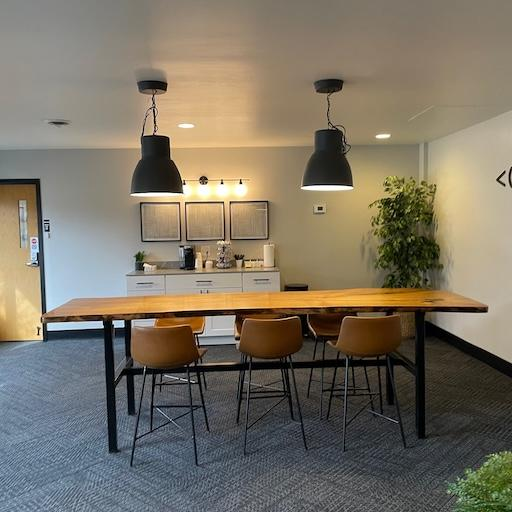

In [9]:
dataset["train"][0]["image"]

The label correctly identifies the objects in the photo!

In [10]:
dataset["train"][0]["label"]

'table, plant, chair, light'

Now, let's take a look at a different image, pair.

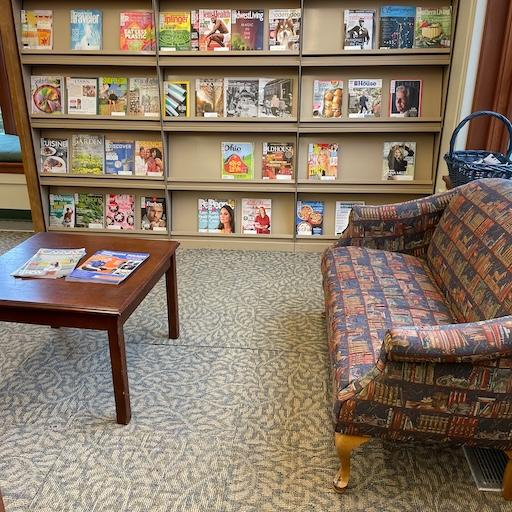

In [11]:
dataset["train"][7]["image"]

Now, let's look at the label.  Hmmm...notice something a bit odd? The model has detected a dog in the image! This seems wrong. However, if you look closely at the bookcase with the magazines, you can see that one of them has a dog on the cover. This highlights the importance of double-checking the predicted labels to make sure they are what you expect.

In [12]:
dataset["train"][7]["label"]

'table, dog, bookcase, book'